In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import special
import ipywidgets as widgets
from ipywidgets import interactive, interact, fixed, interact_manual
from IPython.display import display, clear_output

### Reading in the data files

In [169]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMcNoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMcNoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']
framesListMc = framesMcNoHiggs + [higgs_85, higgs_90, higgs_95]
framesListMcNames = framesMcNoHiggsNames + ['higgs_85', 'higgs_90', 'higgs_95']


# mvisf values are to high for histograms- lower by 10e15
for frame in framesListMc:
    frame['mvisf']/= 10e15
data['mvisf']/= 10e15

### Associate weights with the MC generated data

In [170]:
crossSectionsMc = [102., 16.5, 0.975, 3.35, 2.9, 15600., 0.094, 0.0667, 0.0333]
NumberEntriesMc = [len(frame['encm']) for frame in framesListMc]
NumberMc = [200000., 294500, 196000, 29500, 81786, 5940000, 3972, 3973, 3971]
Lum = 176.773

weights = Lum*np.array(crossSectionsMc) / np.array(NumberMc) 

for i, frame in enumerate(framesListMc):
    frame["weight"] = weights[i]
data["weight"] = 1


Ndata = len(data['encm'])

In [171]:
sum(np.array(NumberEntriesMc[:6])*weights[:6])

659.45883336774511

In [172]:
np.array(NumberEntriesMc)*weights

array([ 273.07716267,  261.38874283,   31.6321755 ,    4.65721951,
         49.24208538,   39.46144747,   14.02710667,   10.08135129,
          4.95708707])

In [173]:
sum(data['encm'])/len(data['encm'])

188.64189391575664

In [174]:
sum([sum(frame['encm']) for frame in framesListMc])/sum(NumberEntriesMc)

188.98910197226905

### Widget that decides which higgs we want to take into account

In [188]:
l = len(framesMcNoHiggs)

higgsDict = {
    'No higgs': 0, #[[],[],[]],
    '85 GeV': l, #[[higgs_85], ['higgs_85'], [weights[len(framesMcNoHiggs)-1]]],
    '90 GeV': l+1, #[[higgs_90], ['higgs_90'], [weights[len(framesMcNoHiggs)]]],
    '95 GeV': l+2, #[[higgs_95], ['higgs_95'], [weights[len(framesMcNoHiggs)+1]]]
    }

widHiggs = widgets.Dropdown(
    options=higgsDict,
    description='higgs mass:',
)

def createFrames(index):
    global frames, names, NMc, signal
    if index > 0:
        signal = framesListMc[index]
        frames = framesMcNoHiggs + [signal]
        names = framesMcNoHiggsNames + [framesListMcNames[index]]
    else:
        frames = framesMcNoHiggs
        names = framesMcNoHiggsNames
    NMc = sum([len(frame['encm'])*frame['weight'][0] for frame in frames])
    return None

dataFrameObject = interactive(createFrames, index=widHiggs)

### Build the histogram

In [178]:
def buildHist (var,Nbins, y_scale):
    plt.figure(figsize=(10,8))
    global bins
    bins = plt.hist([frame[var] for frame in frames], log=y_scale, weights=[frame["weight"] for frame in frames], bins=Nbins, stacked=True, alpha=0.5, label=names)[-2]        
    
    dataCounts, dataBins = np.histogram(data[var], bins)
    #datayErr = np.sqrt(dataCounts) # would give Gaussian errors
    
    # following http://ms.mcmaster.ca/peter/s743/poissonalpha.html
    # and https://newton.cx/~peter/2012/06/poisson-distribution-confidence-intervals/
    lowerErr = dataCounts - np.array( scipy.special.gammaincinv(dataCounts, 0.5*(1-0.6827)) )
    lowerErr = [0 if entry != entry else entry for entry in lowerErr]
    upperErr = np.array( scipy.special.gammaincinv(dataCounts+1, 1 - 0.5*(1-0.6827)) ) - dataCounts
    datayErr = [lowerErr, upperErr] # Poissonian errors
    
    plt.errorbar((dataBins[1:]+dataBins[:-1])/2., dataCounts, yerr =datayErr, label='data', ecolor='red',marker='s', linestyle='')
    plt.legend()
    plt.xlabel('%s' %var)
    plt.ylabel('counts')
    #plt.xlim(.4,1.) for btags
    #plt.ylim(0,15)
    plt.title('%i data points and %.1f Mc (weighted) points' %(Ndata,NMc))
    plt.show()

# Log-likelihood ratio, define signal and background

In [195]:
background = pd.concat(framesMcNoHiggs)

def likelihoodRatio(s,b,n):    #(signal,background,data):
    if len(s) != len(b) or len(s) != len(n):
        print "Signal, background and data must have the same bins!"
        return 0
    res = 0
    for i, si in enumerate(s):
        if n[i] == 0: # 0*ln -> only si remains
            res += si
            #print "a", res
        elif si == 0: # 
            pass
            #print "b", res
        elif b[i] == 0:
            return -np.infty # ln(1+si/bi)= inf
        else: # the normal case
            res += si - n[i]*np.log(1+si/float(n[i]))
            #print "c", res
    return 2*res

def outputLikelihood(Nbins, var):
    print '-2 ln Q ='
    if var == 'all variables':
        for variable in background.columns:
            b,bins = np.histogram(background[variable], bins=Nbins, weights=background['weight'])
            s,_ = np.histogram(signal[variable], bins=bins, weights=signal['weight']) # signal defined as global variable in createFrames
            n,_ = np.histogram(data[variable], bins=bins, weights=data['weight'])
            print ' ', variable,':', likelihoodRatio(s,b,n)
    else:
            b,bins = np.histogram(background[var], bins=Nbins, weights=background['weight'])
            s,_ = np.histogram(signal[var], bins=bins, weights=signal['weight']) # signal defined as global variable in createFrames
            n,_ = np.histogram(data[var], bins=bins, weights=data['weight'])
            print ' ', var,':', likelihoodRatio(s,b,n)


# The histogram widget

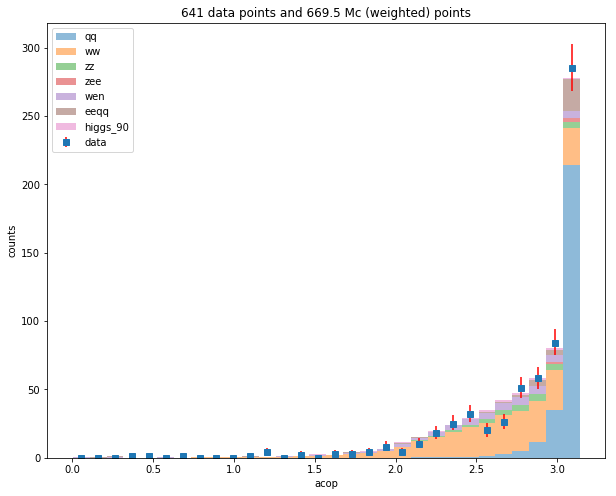

In [208]:
display(dataFrameObject)
#interact_manual(buildHist,var=sorted(dict(zip(data.columns.values,data.columns.values))),Nbins=(10,50), 
interact_manual(buildHist,var=sorted(data.columns.values),Nbins=(10,50), 
                y_scale={'like always': False, 'logarithmic':True}, alpha=.2)

#  The log-likelihood widget

In [210]:
display(dataFrameObject)
interact_manual(outputLikelihood,var=['all variables']+sorted(data.columns.values),Nbins=(10,50))

-2 ln Q =
  irun : 0.064352283997
  ievt : 0.0497589299558
  ifi : 0.901288558852
  idp1 : 9.91417414737
  idp2 : 9.91417414737
  encm : 6.34501091622
  btag1 : 0.143043104969
  btag2 : 0.117732845699
  ucsdbt0 : 0.833497100087
  mvis : 0.0613771827897
  mvisf : 0.0381384649289
  mvissc : 0.0563254544759
  fmvis : 0.0885906277727
  fmmis : 0.128919780907
  fth1 : 0.0482159537691
  mmis : 0.0645781371398
  acthm : 0.048948921507
  maxcthj : 0.04281946427
  acop : 0.0977140512749
  maxxov : 0.0546032970924
  ghmass : 0.0381384649289
  enj1 : 0.056406045965
  thj1 : 0.042307998101
  phj1 : 0.0400200884088
  xmj1 : 0.0473913637499
  enj2 : 0.0753788771843
  thj2 : 0.0553996513478
  phj2 : 0.0401752457855
  xmj2 : 0.0420977132185
  pho_num : 0.0446480524088
  pho_ene : 0.0432663409049
  pho_the : 0.0605881890952
  pho_phi : 0.0419068072557
  ele_num : 0.0383651104841
  ele_ene : 0.0410238251665
  ele_the : 0.124618140734
  ele_phi : 0.0722514517717
  muon_num : 0.0393110334602
  muon_ene : 

When -lnQ > 0, lnQ < 0 and thus Q < 1. This means that the background-only hypothesis is more likely than the signal hypothesis. The higher the value, the less likely the signal is to exist.

# Try stuff

In [61]:
background = pd.concat(framesMcNoHiggs)
signalAndBackground = pd.concat(framesMcNoHiggs+[higgs_85])
p_background = sum(background['weight']) / (sum(background['weight']) + sum(signal['weight']))
p_signal = sum(signal['weight']) / (sum(background['weight']) + sum(signal['weight']))

var = 'mvis'
Nbins = 30

counts_background, bins = np.histogram(background[var], bins=Nbins, weights=background['weight'])
counts_signal, binss = np.histogram(signal[var], bins=bins, weights=signal['weight'])

#p_background_COND_bin = counts
print counts_background, bins, binss


[  0.07147442   0.12625903   2.06933969   4.41044948   6.98325873
   9.5720267   15.66401084  13.66254779  16.43996699  22.98817901
  24.8417519   29.3467422   37.81712023  41.4077602   45.03764669
  45.63780051  44.07823091  38.02114525  35.37522795  33.09353422
  30.3074837   30.28630261  25.29766693  24.60628553  21.78345576
  17.64014788  15.80755076  13.90838738   8.85635196   4.32072812] [  40.4692       43.73112667   46.99305333   50.25498      53.51690667
   56.77883333   60.04076      63.30268667   66.56461333   69.82654
   73.08846667   76.35039333   79.61232      82.87424667   86.13617333
   89.3981       92.66002667   95.92195333   99.18388     102.44580667
  105.70773333  108.96966     112.23158667  115.49351333  118.75544
  122.01736667  125.27929333  128.54122     131.80314667  135.06507333
  138.327     ] [  40.4692       43.73112667   46.99305333   50.25498      53.51690667
   56.77883333   60.04076      63.30268667   66.56461333   69.82654
   73.08846667   76.35039333

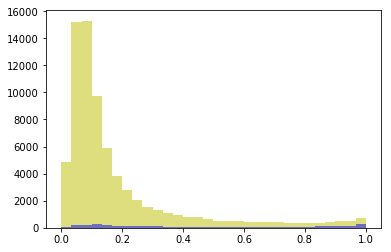

116.399


In [71]:
frame = higgs_85
normed = False
var='btag1'
#plt.plot(frame['btag1'],frame['btag2'], linestyle='', marker='.', markersize='1')
#plt.plot(background['btag1'],background['btag2'], linestyle='', marker='.', markersize='1', color='r')
c, bins,_ = plt.hist(background[var], bins=30, normed=normed, alpha=.5, color='y')
plt.hist(frame[var],bins=bins, normed=normed, alpha=.5, color='b')
plt.show()

print max(frame['mvis'])
